1. Data Exploration and Understanding

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# Load the dataset
df = pd.read_csv("student_success_dataset.csv")



In [5]:
# Display basic information
print(df.info())
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   student_id                500 non-null    object 
 1   age                       500 non-null    int64  
 2   gender                    500 non-null    object 
 3   socioeconomic_status      500 non-null    object 
 4   previous_gpa              500 non-null    float64
 5   attendance_rate           500 non-null    float64
 6   participation_score       500 non-null    float64
 7   assignment_completion     500 non-null    float64
 8   family_support            500 non-null    object 
 9   study_resources           500 non-null    object 
 10  study_hours_per_week      500 non-null    float64
 11  first_generation_student  500 non-null    bool   
 12  program_of_study          500 non-null    object 
 13  digital_literacy          500 non-null    float64
 14  previous_c

In [6]:
# Check for missing values
print(df.isnull().sum())



student_id                  0
age                         0
gender                      0
socioeconomic_status        0
previous_gpa                0
attendance_rate             0
participation_score         0
assignment_completion       0
family_support              0
study_resources             0
study_hours_per_week        0
first_generation_student    0
program_of_study            0
digital_literacy            0
previous_course_failures    0
extracurricular_hours       0
work_hours_per_week         0
distance_from_campus        0
final_grade                 0
completed_course            0
dtype: int64


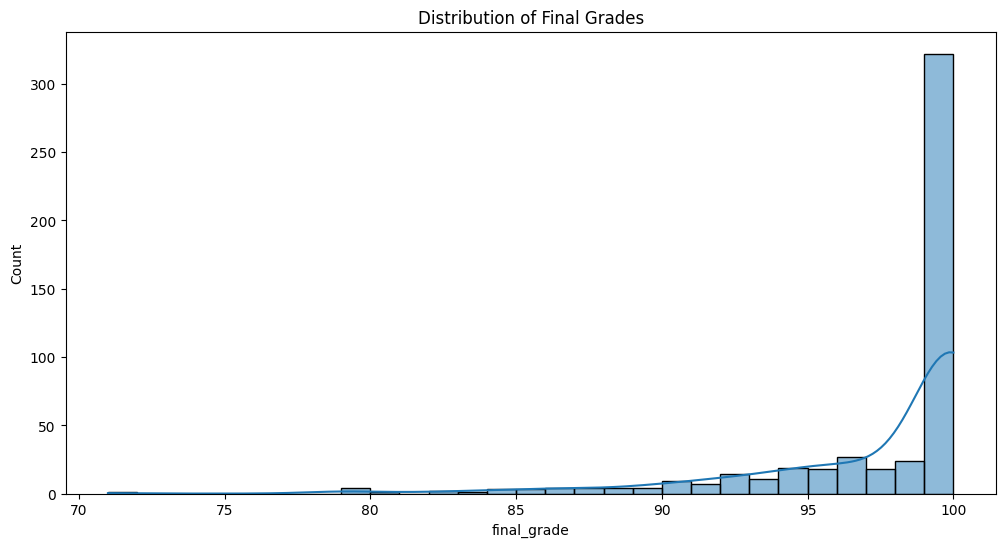

In [7]:
# Visualize distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['final_grade'], kde=True)
plt.title("Distribution of Final Grades")
plt.show()



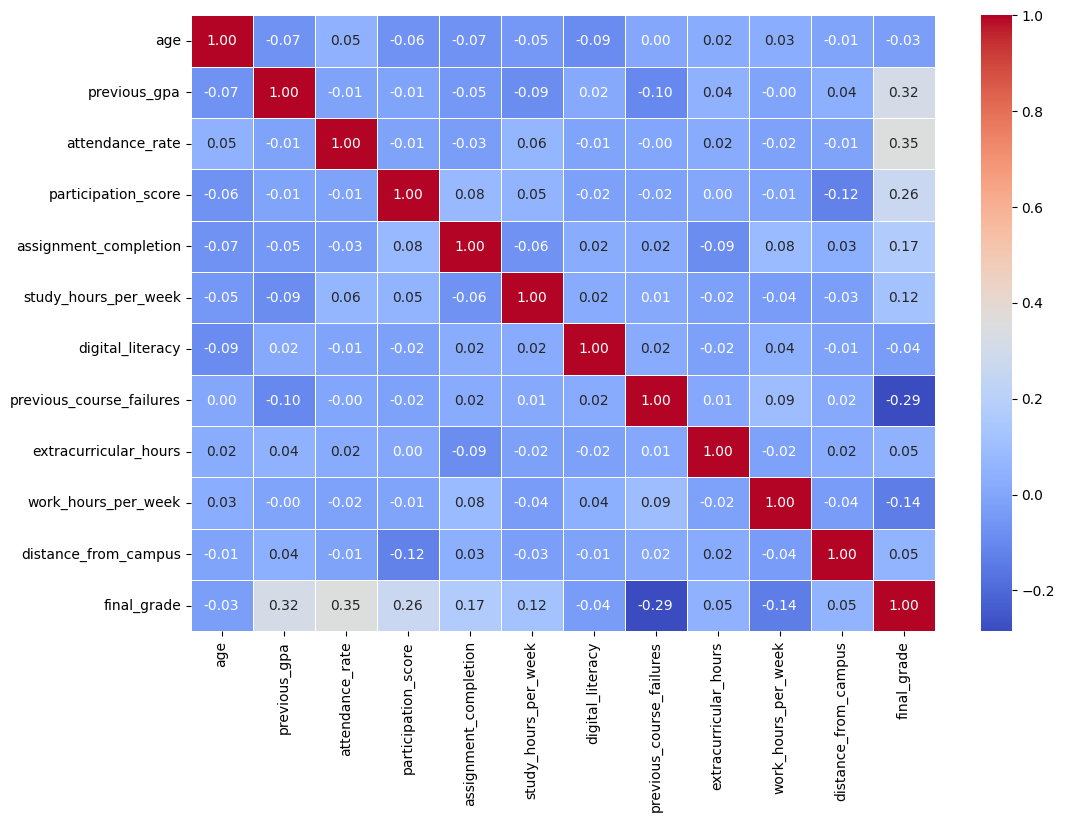

In [10]:
df_numeric = df.select_dtypes(include=[np.number])  # Keep only numeric columns
correlation_matrix = df_numeric.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()


2. Data Preprocessing

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate features and target
X = df.drop(columns=["final_grade", "completed_course"])
y = df["final_grade"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),  # Handle missing values
    ("scaler", StandardScaler())  # Standardize numerical features
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Handle missing values
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # Encode categorical features
])

# Combine pipelines
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

3. Feature Engineering

In [12]:
# Example: Create a derived feature (study efficiency)
df["study_efficiency"] = df["study_hours_per_week"] / df["assignment_completion"]

# Add the new feature to the dataset
X_train["study_efficiency"] = X_train["study_hours_per_week"] / X_train["assignment_completion"]
X_test["study_efficiency"] = X_test["study_hours_per_week"] / X_test["assignment_completion"]

# Re-run preprocessing to include the new feature
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

4. Model Development

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name}: MSE = {mse:.2f}, R2 = {r2:.2f}")

# Compare model performance
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['MSE']:.2f}, R2 = {metrics['R2']:.2f}")

Linear Regression: MSE = 10.89, R2 = 0.47
Ridge Regression: MSE = 10.83, R2 = 0.48
Lasso Regression: MSE = 17.57, R2 = 0.15
Linear Regression: MSE = 10.89, R2 = 0.47
Ridge Regression: MSE = 10.83, R2 = 0.48
Lasso Regression: MSE = 17.57, R2 = 0.15


5. Analysis & Interpretation

                     Feature  Coefficient
292  cat__student_id_STU0345     5.663847
144  cat__student_id_STU0169     5.526944
41   cat__student_id_STU0041     5.497473
36   cat__student_id_STU0035     5.446769
246  cat__student_id_STU0287     5.423438
..                       ...          ...
154  cat__student_id_STU0182    -9.718215
268  cat__student_id_STU0311    -9.931968
205  cat__student_id_STU0241   -10.642791
150  cat__student_id_STU0177   -11.321116
114  cat__student_id_STU0136   -11.806031

[446 rows x 2 columns]


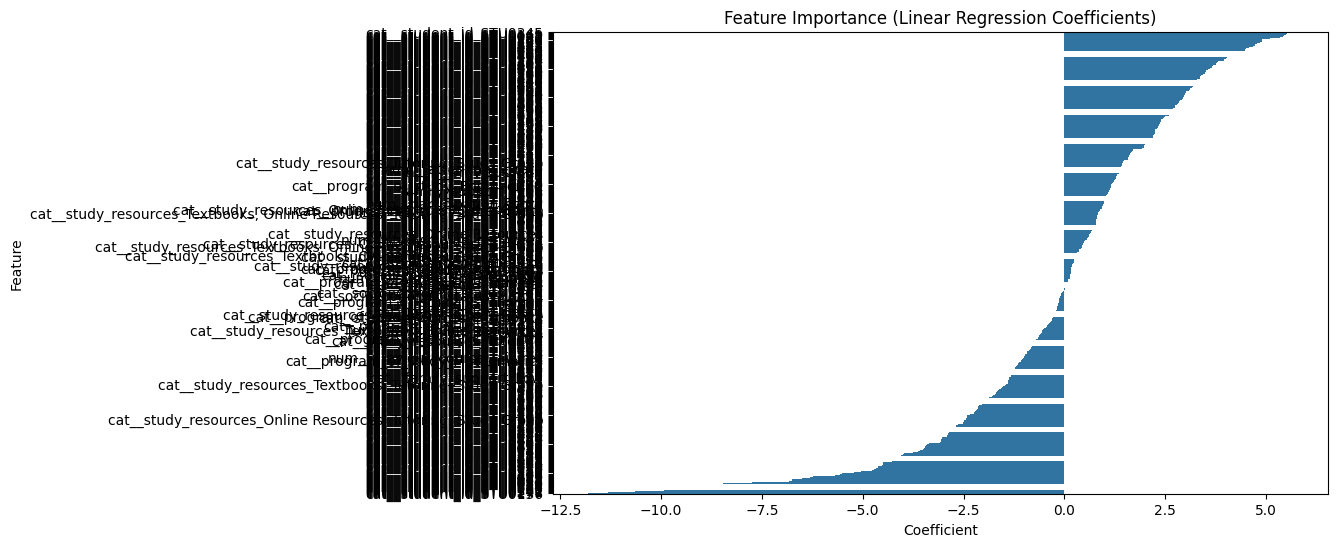

In [14]:
# Interpret model coefficients (for linear regression)
linear_model = models["Linear Regression"]
coefficients = linear_model.coef_
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print(coef_df.sort_values(by="Coefficient", ascending=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df.sort_values(by="Coefficient", ascending=False))
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.show()

6. Final Presentation

In [15]:
# Create a summary of findings
summary = {
    "Best Model": min(results, key=lambda x: results[x]["MSE"]),
    "Best MSE": results[min(results, key=lambda x: results[x]["MSE"])]["MSE"],
    "Best R2": results[min(results, key=lambda x: results[x]["MSE"])]["R2"],
    "Top Features": coef_df.sort_values(by="Coefficient", ascending=False).head(5)["Feature"].tolist()
}

print("Project Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

Project Summary:
Best Model: Ridge Regression
Best MSE: 10.829583938625426
Best R2: 0.4767204652860788
Top Features: ['cat__student_id_STU0345', 'cat__student_id_STU0169', 'cat__student_id_STU0041', 'cat__student_id_STU0035', 'cat__student_id_STU0287']
